# 1. Read Data (ROOT file)

In [1]:
# import ROOT
import math
import uproot
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.patches as patches
from scipy.stats import norm

file = uproot.open("test-minimal-gamma-5Tz-20GeV-2000evts.root")

ntuple = file["tuple"]

# Access and analyze the data in each branch
event_ids = ntuple["eventID"]
num_hits = ntuple["numHits"]
hit_y = ntuple["HitY"]
hit_z = ntuple["HitZ"]
sig = ntuple["sig"]

ntuple.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
eventID              | float                    | AsDtype('>f4')
numHits              | float                    | AsDtype('>f4')
HitY                 | float                    | AsDtype('>f4')
HitZ                 | float                    | AsDtype('>f4')
sig                  | float                    | AsDtype('>f4')


## 2.1 Unpack Data

In [23]:
def get(df, event):
    return df[df["eventID"] == event].copy()

# convert ntuple to pandas df
df = ntuple.arrays(["eventID", "numHits", "HitY", "HitZ", "sig"], library="pd")

# extract true hits
true_hits = df[(df["HitY"] < 1000000) & (df["numHits"] > 0)].copy()
true_hits["y_index"] = true_hits["HitY"] % 10000
true_hits["layer"] = (true_hits["HitY"] - true_hits["y_index"]) / 10000
true_hits["z_index"] = true_hits["HitZ"] % 10000
true_hits["n_neighbors"] = (true_hits["HitZ"] - true_hits["z_index"]) / 10000
true_hits["energy"] = true_hits["sig"] % 10
true_hits["neighbor_energy"] = (true_hits["sig"] / 10).astype(int) / 10000.
true_hits = true_hits[["eventID", "numHits", "y_index", "z_index", "layer", "n_neighbors", "energy", "neighbor_energy"]]

# extract Outside Energy data
outside = df[(df["HitY"] >= 1000000)].copy()
outside["HitY"] = outside["HitY"] / 1000000
outside.rename(columns = {"HitY": "layer", "HitZ": "energy_full", "sig": "energy_below"}, inplace = True)

# extract MIPs data
mips = df[(df["numHits"] < 0)].copy()
mips = mips[mips["sig"]>=2]

mips["y_index"] = mips["HitY"] % 10000
mips["layer"] = (mips["HitY"] - mips["y_index"]) / 10000
mips.rename(columns = {"HitZ": "z_index"}, inplace = True)
mips = mips[["eventID", "numHits", "y_index", "z_index", "layer", "sig"]]
mips["KE"] = mips["sig"] % 1

true_hits.to_csv("true_hits.csv", index = False)
mips.to_csv("mips.csv", index = False)

In [39]:
def double_count_mips(df1, df2):
    columns = ['layer']
    
    # Remove duplicate coords in df1 for safety, then inner merge
    df1_unique = df1.drop_duplicates(subset=columns, keep='first')
    overlapping_mips = pd.merge(df1_unique[columns], df2, on=columns, how='inner')
    
    # Filter rows where layer > 20, then append
    rows_to_duplicate = overlapping_mips[overlapping_mips['layer'] > 20]
    result = pd.concat([overlapping_mips, rows_to_duplicate], axis=0).reset_index(drop=True)
    
    return result

def visible_double_count_mips(df1, df2):
    columns = ['eventID','layer','y_index','z_index']
    
    # Remove duplicate coords in df1 for safety, then inner merge
    df1_unique = df1.drop_duplicates(subset=columns, keep='first')
    overlapping_mips = pd.merge(df1_unique[columns], df2, on=columns, how='inner')
    
    # Filter rows where layer > 20, then append
    rows_to_duplicate = overlapping_mips[overlapping_mips['layer'] > 20]
    result = pd.concat([overlapping_mips, rows_to_duplicate], axis=0).reset_index(drop=True)
    
    return result

def double_count_clusters(df):
    # Filter rows where layer > 20, then append
    rows_to_duplicate = df[df['layer'] > 20]
    result = pd.concat([df, rows_to_duplicate], axis=0).reset_index(drop=True)
    return result

In [36]:
data = []
for i in range(10):
    event = (i+1)*200-1
    data.append(pd.read_csv('data'+str(event)+"_correct", index_col=0))

data = pd.concat(data, ignore_index=True)
data = double_count_clusters(data)
data

,cluster_size,num_mips,min_y,min_z,max_y,max_z,layer,energy,eventID
0,1,1.0,999.0,199.0,999.0,199.0,0,0.002457,0
1,1,1.0,1000.0,200.0,1000.0,200.0,0,0.002457,0
2,1,1.0,993.0,162.0,993.0,162.0,1,0.002234,0
3,1,1.0,999.0,199.0,999.0,199.0,1,0.002625,0
4,1,1.0,1000.0,200.0,1000.0,200.0,1,0.009064,0
...,...,...,...,...,...,...,...,...,...
3630205,1,2.0,1327.0,362.0,1327.0,362.0,37,0.006348,1999
3630206,1,2.0,1345.0,67.0,1345.0,67.0,39,0.009277,1999
3630207,2,0.0,1399.0,72.0,1400.0,72.0,39,0.010254,1999
3630208,1,2.0,987.0,242.0,987.0,242.0,39,0.010132,1999


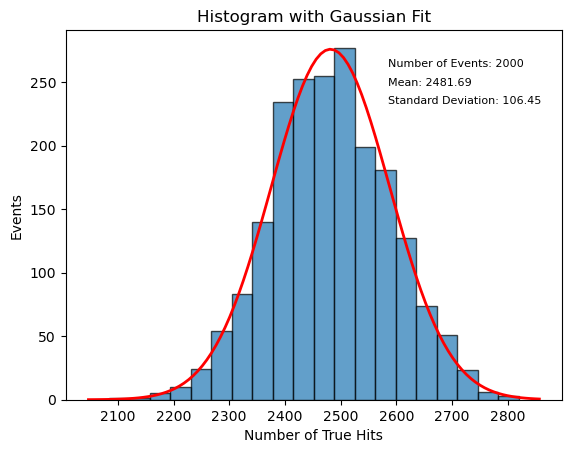

<Figure size 1000x800 with 0 Axes>

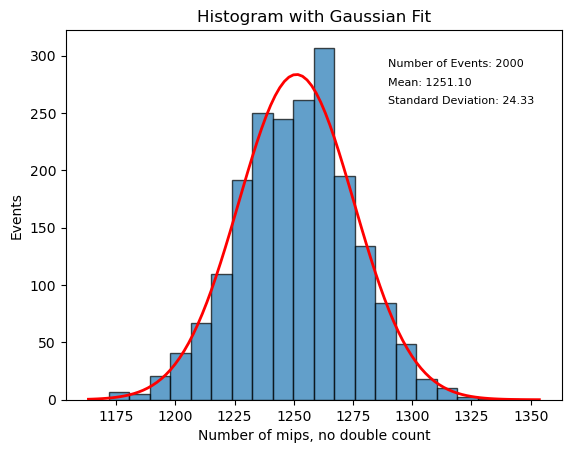

<Figure size 1000x800 with 0 Axes>

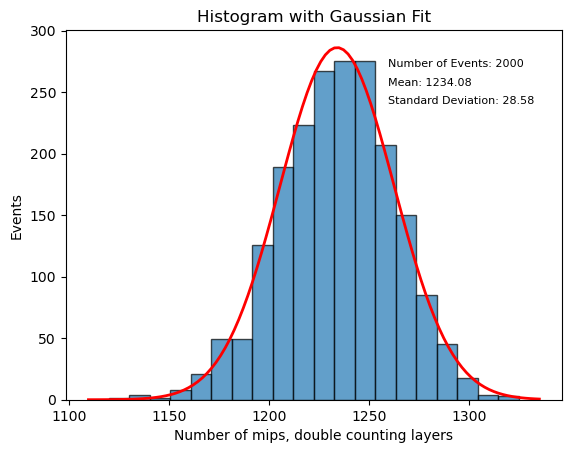

<Figure size 1000x800 with 0 Axes>

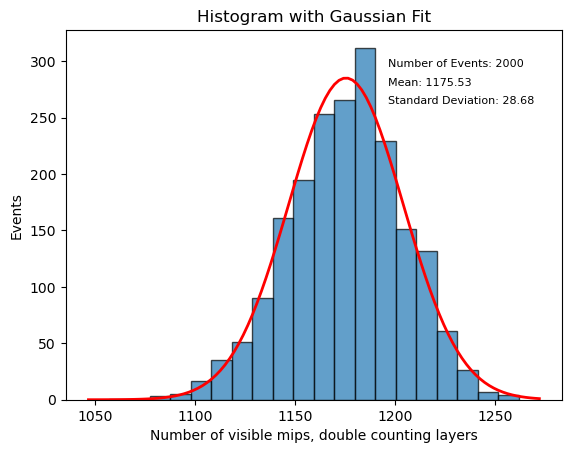

<Figure size 1000x800 with 0 Axes>

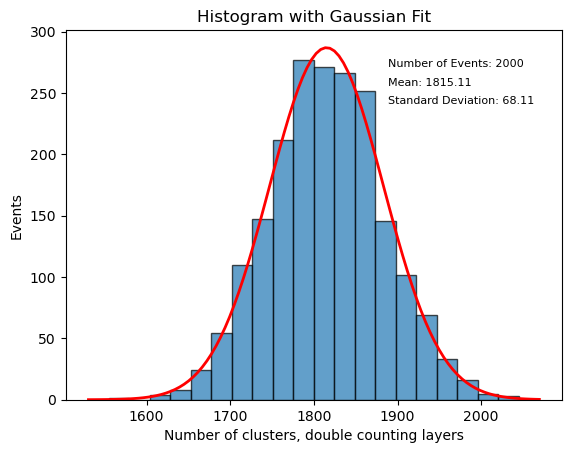

<Figure size 1000x800 with 0 Axes>

In [41]:
def plot_gaussian_histogram(hist_data, ylabel = "ylabel", xlabel = 'xlabel', name = 'Histogram with Gaussian Fit'):
    # Plot the histogram with initial bars
    n, bins, patches = plt.hist(hist_data, bins=20, edgecolor='black', alpha=0.7)  # Alpha for transparency

    # Fit a Gaussian curve to the histogram data
    (mu, sigma) = norm.fit(hist_data)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, sigma)

    # Scale the Gaussian curve to match the histogram
    scaling_factor = len(hist_data) * np.diff(plt.hist(hist_data, bins=20, density=True)[1])[0]
    plt.plot(x, p * scaling_factor, 'r', linewidth=2)  # 'r' for red color

    # Set labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(name)

    # Add statistics text to the plot
    plt.text(0.65, 0.9, f'Number of Events: {len(hist_data)}', transform=plt.gca().transAxes, fontsize=8)
    plt.text(0.65, 0.85, f'Mean: {mu:.2f}', transform=plt.gca().transAxes, fontsize=8)
    plt.text(0.65, 0.8, f'Standard Deviation: {sigma:.2f}', transform=plt.gca().transAxes, fontsize=8)

    # Set y scale to exponential
#     plt.yscale("log")

    # Show the plot
    plt.figure(figsize = (10,8))
    plt.show()


hist_th = list(map(lambda x: get(true_hits, x)["numHits"].unique()[0], true_hits["eventID"].unique()))

# extract mips with sig > 2
mips_filtered = mips[mips["sig"] >= 2]
# mips_filtered = mips

# prep hist data
hist_mips = mips_filtered.groupby("eventID").size().tolist()
hist_mips_double = double_count_mips(true_hits, mips_filtered).groupby("eventID").size().tolist()
hist_mips_visible = visible_double_count_mips(true_hits, mips_filtered).groupby("eventID").size().tolist()
hist_clusters = data.groupby("eventID").size().tolist()

# plot it
plot_gaussian_histogram(hist_th,"Events", "Number of True Hits")
plot_gaussian_histogram(hist_mips,"Events", "Number of mips, no double count")
plot_gaussian_histogram(hist_mips_double,"Events", "Number of mips, double counting layers")
plot_gaussian_histogram(hist_mips_visible,"Events", "Number of visible mips, double counting layers")
plot_gaussian_histogram(hist_clusters,"Events", "Number of clusters, double counting layers")

In [9]:
def plot_cluster_frequency(true_hits,mips,to_event = 1):
    cluster_data = {}
    for event in range(to_event):
        if event %10 == 0:
            print("Finished", event)
        merged_data = merge_data(get(true_hits,event),get(mips,event))
        cluster_data[event] = produce_cluster_data(cluster(merged_data))
        
    # Get cluster sizes
    # cluster_sizes = list(cluster_length.values())
    cluster_sizes = []
    for i in range(to_event):
        cluster_sizes += list(cluster_data[i][1].values())

    # Generate a histogram
    plt.hist(cluster_sizes, bins=range(min(cluster_sizes), max(cluster_sizes) + 1, 1), alpha=0.7, rwidth=1)

    plt.title('Histogram of Cluster Sizes')
    plt.xlabel('Cluster Size')
    plt.ylabel('Frequency')

    plt.yscale('log')  # Set logarithmic scale for y-axis

    # Generate gridlines based on the new scale
    y_vals = plt.gca().get_yticks()
    plt.gca().set_yticks(y_vals, minor=True)
    plt.gca().yaxis.grid(True, which='both')

    plt.show()
    
plot_cluster_frequency(true_hits, mips, 200)

Finished 0
Finished 10



KeyboardInterrupt



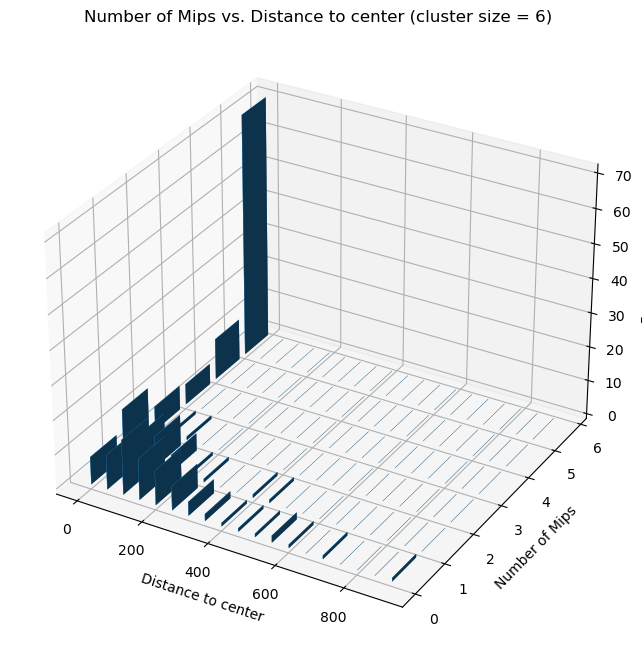

In [32]:
from mpl_toolkits.mplot3d import Axes3D

def plot_mips_vs_radius_3d(cluster_data):
    # Initialize lists to store the number of mips and radius for each cluster
    mips_counts = []
    radii = []

    # Loop over each event
    for event_data in cluster_data.values():
        # Loop over each cluster in the event
        for i, length in event_data[1].items():
            if length == 6:
                cluster = event_data[0][i]

                # Convert the cluster to a DataFrame
                cluster_df = pd.DataFrame(cluster, columns=['z_index', 'y_index', 'type'])

                # Calculate the number of mips in the cluster
                num_mips = (cluster_df['type'] == 'mips').sum()
                mips_counts.append(num_mips)

                # Calculate the radius of the cluster
                radius = calculate_radius(cluster_df)
                radii.append(radius)

    # Compute the 2D histogram
    radius_bins = np.arange(min(radii), max(radii) + 50, 50)
    hist, xedges, yedges = np.histogram2d(radii, mips_counts, bins=(radius_bins, np.unique(mips_counts)))

    # Create a meshgrid for the bar positions
    xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = 0

    # Compute the width, depth, and height of each bar
    dx = dy = 0.8 * np.ones_like(zpos)
    dz = hist.ravel()

    fig = plt.figure(figsize=(13, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot a 3D bar plot
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

    # Set labels
    ax.set_xlabel('Distance to center')
    ax.set_ylabel('Number of Mips')
    ax.set_zlabel('Frequency')

    # Set title
    ax.set_title('Number of Mips vs. Distance to center (cluster size = 6)')
    plt.show()

# Create the plot
plot_mips_vs_radius_3d(cluster_data)


In [348]:
# regress energy, 
# see the fractal dimension of photon, and compare to literature

# plot the p.18, p.22
# Redo the my last slides in histogram. 2D, also the 2nd to last page.

# read more about calorimeter, how energy reconstruction work

7.26
#agglomerative clustering
# 1. just reconstructing energy
# 2. first separate clusters then reconstruct

# ask lindsey if he can give us more data on different energies of particles using the software Jim might have given him，
# and timing information if possible